In [1]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from PIL import Image
import os
from tifffile import imread
import matplotlib.pyplot as plt
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from plot_utils import singleplot, plotXY, doubleplot
from GaussFit import StripFit, Linescan, ShiftFit,FinalShiftFit, MegaBlock
from HoughLine import show_hough_linetransform, show_ransac_points_line, show_plot, Correlation_plot,show_intensity_plot, Peak_Data
from bokeh.models import Label
from bokeh.io import export_png
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
from bokeh.models import Range1d
import csv
from GaussFit import MakePath

/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed

In [2]:
targetdir = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/'

Membraneimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Membrane.tif'

Actinimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Actin.tif'


#Enter time unit in seconds
Time_unit = 5
#Enter pixel to micrometer conversion
Xcalibration = 0.1032
#Enter the number of pixels to be included in the fit
Fitaround= 8


#Symmetric psf as input (micrometers)
psf = 0.17

showaftertime = 100
inisigmaguess =  psf
#Size of linescan
skip = 50
singleblock = 40 

#Number of segments
numsegments = 10
#Number of brightest peaks to be taken from each block
Npeaks = 100

id = []
for i in range(0, numsegments):
    id.append(i)
    
MakePath(targetdir)    
save_dir = targetdir + 'ls_data_block'    
MakePath(save_dir)


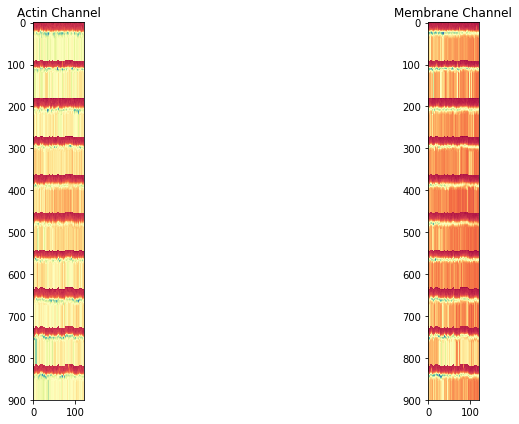

In [12]:
Actin = imread(Actinimage)
Membrane = imread(Membraneimage)
Time = Actin.shape[1]

doubleplot(Actin, Membrane, 'Actin Channel', 'Membrane Channel')
blockimageActin = []
blockimageMembrane = []

i = 0
while i < Actin.shape[0]:
       
   blockActin = Actin[i:i + singleblock,:]#/np.amax(Actin[i:i + singleblock,:], 0)
   blockMembrane = Membrane[i:i + singleblock,:]#/np.amax(Membrane[i:i + singleblock,:],0)
   
   blockimageActin.append(blockActin)
   blockimageMembrane.append(blockMembrane)
   #doubleplot(blockActin, blockMembrane, 'Actin Channel', 'Membrane Channel')
   i = i + singleblock + skip + 1 

halflength = int(len(blockimageActin)/2)
otherhalf = len(blockimageActin) - halflength
totallength = len(blockimageActin)


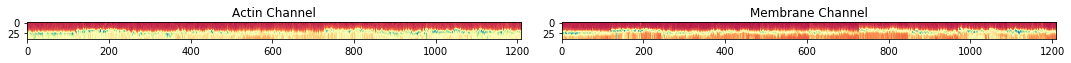

In [4]:

MegaBlockActin = MegaBlock(blockimageActin)
MegaBlockMembrane = MegaBlock(blockimageMembrane)

doubleplot(MegaBlockActin, MegaBlockMembrane, 'Actin Channel', 'Membrane Channel')

In [7]:
print(MegaBlockActin.shape[0],MegaBlockActin.shape[1] )

40 1210


block id 1
(40, 1210)


/Users/aimachine/PyImage/utils/GaussFit.py:632: RuntimeWarning: invalid value encountered in true_divide
  m_left = (self.i[self.left_index_right] - self.i[self.left_index_left]) /  (self.x[self.left_index_right] - self.x[self.left_index_left])
/Users/aimachine/PyImage/utils/GaussFit.py:648: RuntimeWarning: invalid value encountered in true_divide
  m_right = (self.i[self.right_index_right] - self.i[self.right_index_left]) / (self.x[self.right_index_right] - self.x[self.right_index_left])
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/aimachine/PyImage/utils/GaussFit.py:648: RuntimeWarning: invalid value encountered in double_scalars
  m_right = (self.i[self.right_in

Membrane Fit: (Amp, Sigma, PeakPos, C) [ 3.54760401e+05  9.59153625e+00  1.45894487e-02 -1.45958031e+04]
Actin Fit: [ 2.00833313e+04  4.44546104e+00  1.70441554e-01 -1.65784098e+03]


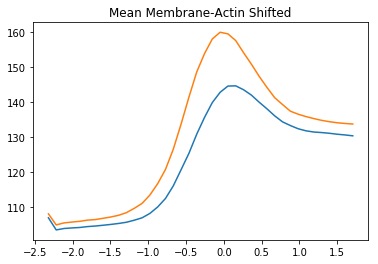

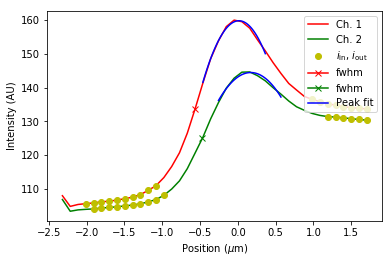

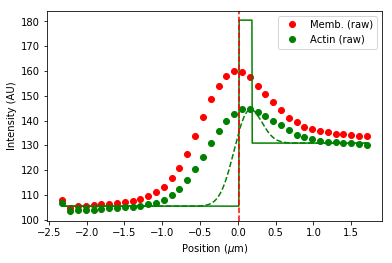

Thickness (nm), center cortex , cortical actin intensity (from fit) 174.9886370743832 0.10208376726837042 180.55215359003935


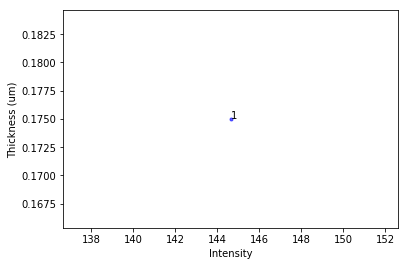

Thickness (min) 174.9886370743832 nm
Thickness (median) 174.9886370743832 nm
Thickness (max) 174.9886370743832 nm
CPU times: user 17.2 s, sys: 180 ms, total: 17.4 s
Wall time: 17.5 s


In [11]:
%%time
global Thickness, Intensity, PeakActin, DataActin, PeakMembrane, DataMembrane, Time, ID, BlockAverageActin, BlockAverageMembrane
global Thickness_intensity, Thickness_id
#Fit all blocks

Thickness = []
Intensity = []
PeakActin = []
DataActin = []
PeakMembrane = []
DataMembrane = []

ID = []

BlockAverageActin = []
BlockAverageMembrane = []
i =0
    
BlockActin = []
BlockMembrane = []
    

Actin = MegaBlockActin
Membrane = MegaBlockMembrane

MegaFit(Membrane, Actin, Npeaks, Time_unit, Xcalibration, Fitaround, psf, inisigmaguess, Thickness, Intensity, PeakActin, BlockActin, PeakMembrane, BlockMembrane, BlockAverageActin,BlockAverageMembrane, Time, ID)
Correlation_plot(Thickness, Intensity, ID)
 
print("Thickness (min)",np.min(Thickness) *1000, "nm")
print("Thickness (median)",np.median(Thickness) *1000, "nm")
print("Thickness (max)",np.max(Thickness) *1000, "nm")
 
Thickness_intensity = np.column_stack([Thickness, Intensity]) 
 
Thickness_id = np.column_stack([Thickness, ID]) 
 

 #clear_output(wait = True)
    


In [ ]:

master_data= []

Path(save_dir).mkdir(exist_ok = True)

for line in Thickness_id:
    master_data.append(line)
file =    open(save_dir + "/" + ( "Block" + os.path.basename(Actinimage))  +".csv", "w")
writer = csv.writer(file)
writer.writerows(master_data) 
file.close()


In [ ]:
num_clusters = 2
show_intensity_plot(Thickness_intensity,save_dir,os.path.basename(Actinimage), ymin = 0, ymax = 0.5, num_clusters = num_clusters )



FinalThickness = []
FinalIntensity = []
FinalTime = []
FinalShiftFit(BlockAverageActin, BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,FinalThickness, FinalIntensity,   FinalTime, 0)

Final_master_data= []
Final_Thickness = np.column_stack([FinalThickness, os.path.basename(Actinimage)]) 


for line in Final_Thickness:
    Final_master_data.append(line)
Final_file =    open(save_dir + "/" + ( "Master" + os.path.basename(Actinimage))  +".csv", "w")
writer = csv.writer(Final_file)
writer.writerows(Final_master_data) 
Final_file.close()



In [ ]:
hist, edges = np.histogram((Thickness), density=False, bins='auto')
p = figure(title="Estimated Cortex Thickness = " + str('%.5f'%np.abs(edges[np.argmax(hist)] * 1000)) + 'nm', y_axis_label='Counts',x_axis_label='Thickness(um)')
listedges = edges.tolist()
listhist = hist.tolist()
output_notebook()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color="#036564", line_color="#033649")
for  i in range(0,len(listhist)):
  if listhist[i] > 0:
   mytext = Label(x=listedges[i], y=listhist[i], text=str('%.4f'%listedges[i]))
   p.add_layout(mytext)
show(p)    
export_png(p, filename=save_dir +  "/" +  'Bokeh_Histogram' + os.path.basename(Actinimage) + '.png')    